CS244 Assignment 3 - Group 8
===============

* Kevin Rothi (leader)
* J.Y. Ku
* John Lanier 

Github Repository 
https://github.com/JBLanier/cs244fall2017/ 

Both a PDF and an HTML version of this report was submitted, the reason being that the HTML version of this jupyter notebook looks much prettier.

Signal Processing
----------------

Our team used Python for this project. The SciPy library has some great components for signal processing in the scipy.signal library. Applying these components to the signal provided in the correct way proved to be both a challenge and a learning experience.

### Filter Challenges

1. Selecting the correct filter type.
2. Selecting the correct cutoff frequencies.
3. Selecting the correct number of poles to use.
4. Applying the filter to the signal.

First, the filter type wasn't obvious. The team eventually went with a Butter bandpass filter for the heart rate and respiration rate calculations since these signals needed both the high and low frequencies filtered out, since the signal we wanted to isolate occupies a specific band of frequencies. For the SPO2 calculations, after exhaustive experimentation, the team eventually got the best results with a lowpass filter. We theorize that this is because the DC component is a very low frequency wave, and using a bandpass filter would remove it, but more investigation would be needed to confirm this completely.

Selecting the cutoff frequencies was generally the result of experimentation. Too much filtering would remove the peaks, resulting in sine wave like behaviour. This actually made peak detection easier, which this report will cover in the next section, but the tradeoff was that the smooth sine wave would lack detail pertaining to the heart rate which we wanted to keep (the wave would be too smooth).

The correct response curve (pole number) was also not immediately obvious. We eventually settled with a value of 4 since this seemed to give us the best result.

Applying the filter to the signal also proved to be an interesting exercise in signal processing. Using the signal, lfilter method would induce a frequency dependent phase shift to the signal. In the case of the breathing and respiration rate calculations, this wasn't necessarily a bad thing, but with the SPO2 calculation it was imperative that the signal remained in phase if we wanted to use the same peak and valley locations for both signals. We did experiment with working around the phase shift issue be finding the peaks and valleys for both the filtered signals, but this proved to be problematic and this approach was eventually abandoned in favor of using the signal.filtfilt method to apply the filter, which does not induce a phase shift. We also used [Gustafsson’s method](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.signal.filtfilt.html#r216) when applying the filter with filtfilt since we wanted to minimize the transient induced at the beginning of the signal.

Peak Detection
-------------

After the signals had been properly filtered, the next step was to perform peak detection with additional valley detection necessary for the SPO2 calculations. This proved to be as challenging as the filtering step since Python's primary methods for peak and valley detection didn't perform well in practice.

### Peak Detection Challenges

1. Selecting the correct order for signal.argrelextrema
2. Selecting the correct comparator function for signal.argrelextrema
3. Experimenting with peakutils
4. Eventually settling for a new approach (moving subsection of the signal)

SciPy's signal.argrelextrema and it's siblings argrelmax and argrelmin take an argument called "order" which controls how the function looks for peaks, comparing the values around a suspected point using the comparator function out to the value specified with order. The problem is that values of order that are too small would result in false positives, but values too large would miss peaks and valleys. Selecting the correct order proved to be very challenging since accurate peak detection 100% of the time was critical for success, especially in the case of the SPO2 calculations.

On the topic of the comparator function, the choices are the typical greater or less, but also greater_equal and less_equal. If the signal was dramatically filtered, the latter proved to be more effective at correctly finding peaks.

The team also experimented with the peakutils library, but this proved to exhibit the same challenges that were associated with the use of argrelextrema, specifically selecting parameters that were robust to noise and variations in the signal's periodicity.

The team eventually came up with a new method specifically for calculating the SPO2 levels. The entire signal was parcellated into sections by second. This allowed for a much more controlled peak/valley finding technique which would...

1. Do its best to find 2 valleys within a reasonable distance from each other.
2. Do its best to assure that the peak found was between the two valleys.

The code should largely speak for itself, but argrelextrema is called to find the valleys in the signal chunk. Then the peaks are found, and only the peak that landed between the two valleys is kept.

*This works well because it avoids the continuity problems associated with missed valleys and peaks when processing the signal as a whole.*

After we've found the appropriate peaks and valleys, the rest was fairly trivial. For the heart rate and respiration rate calculations, the formula to convert the time between peaks to a per minute rate was simple algebra. The SPO2 calculation was more involved.

### Calculating SPO2

First, we need to find the DC values for the both the IR and red signals. This is accomplished by finding two adjacent valleys and determining their actual values at those points. We then generate a line connecting the two points with numpy's interp function. We then find the peak between the two valleys, and ascertain the interpolated value where the peak is. This is the DC value. The AC value is simply the difference between the value at the peak and the DC value.

This was easily the most challenging part of the assignment. Applying the appropriate filtering and finding the peaks/valleys represented the bulk of the work done, but the final result seems satisfactory. 

### Final Notes

Something you might notice is that in our results we have the heart rate and respiration rate as peak to peak values. For SPO2, we have it broken down by second. This is a consequence of the two different methods we used to derive our results. The Heart Rate, Respiration Rate, and SPO2 values in each row of the csv do not correspond to the explicit time values on the same rows, nor do they correspond to each other in time.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import math
import pandas as pd
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import sklearn
%matplotlib inline

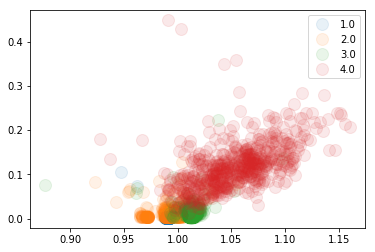

Cross Validation Accuracy: 0.8679166666666667
0.976666666667
---------- PRINTING SPO2 VALUES -----------
97.2695659738
94.1369820763
95.1698552093
87.0593803861
95.9284393535
96.4132611682
96.2824831008
95.659880102
95.706786573
95.8426937298
96.2433678428
92.1725243544
93.8335397296
95.6807152331
90.3295067991
91.1944005731
97.0252957607
88.7114576707
92.9487180072
96.6869673368
98.3538075948
89.8621111139
95.7790013996
94.9234389935
96.4347827277
97.8498672769
92.6370267036
92.5418184422
98.0877362887
97.5541810592
99.1503069097
96.2418086307
98.1223215103
97.045263049
97.9840425232
96.4791950632
97.9647695378
90.8202877193
95.0074073741
97.1066364729
96.5148795674
98.6429086089
96.5045159379
95.2365595381
97.1038404659
96.4957791734
93.0683247678
95.7733326225
94.9733553349
98.2947749367
98.3103623278
93.0957916809
96.3119632557
96.242710362
90.4000576593
91.1136234579
96.7697547116
99.2091056211
96.8368490247
97.3146920459
96.9836856162
98.5245487276
96.6882934756
96.472685436
97.1

In [5]:
# Generate our Final Training Data from windows of raw data (std magnitude and mean magnitude)
def getGeneratedFeatureData(raw_data, window_size):
    gen_features = np.full(((len(raw_data)//window_size),3),-1.0)
    for window_num, window_start_index in enumerate(range(0,len(raw_data),window_size)):
        # Check for case in which last window isn't as large as desired window_size
        if (window_start_index + window_size) > len(raw_data):
            #print("Last window at {} was too small, excluding it.".format(window_start_index))
            break
        # Gather magnitudes of data points in window
        window_magnitudes = np.full(window_size,-1.0)
        for window_index, raw_data_index in enumerate(range(window_start_index, window_start_index + window_size)):
            magnitude = np.linalg.norm(raw_data[raw_data_index][-4:-1])
            window_magnitudes[window_index] = magnitude 
            #print("c: {} index: {} W: {} values: {} magnitude: {}".format(raw_data[raw_data_index,-1],raw_data_index,window_num,raw_data[raw_data_index][:-1],magnitude))
       
        #print("Window:\n{}".format(window_magnitudes))
        #print("Mean: {} Std: {}".format(window_magnitudes.mean(),window_magnitudes.std()))
        gen_features[window_num,0] = window_magnitudes.mean()
        gen_features[window_num,1] = window_magnitudes.std()
        gen_features[window_num,2] = raw_data[0,-1]
    return gen_features

# Pull in Raw Training Data
tr_sleeping = np.genfromtxt('sleeping.csv', delimiter=',')[1:]
tr_sitting = np.genfromtxt('sitting.csv', delimiter=',')[1:]
tr_standing = np.genfromtxt('standing.csv', delimiter=',')[1:]
tr_walking = np.genfromtxt('walking.csv', delimiter=',')[1:]

# Add Class Labels
tr_sleeping = np.concatenate((tr_sleeping,np.full((len(tr_sleeping),1),1)),axis=1)
tr_sitting  = np.concatenate((tr_sitting ,np.full((len(tr_sitting) ,1),2)),axis=1)
tr_standing = np.concatenate((tr_standing,np.full((len(tr_standing),1),3)),axis=1)
tr_walking  = np.concatenate((tr_walking ,np.full((len(tr_walking) ,1),4)),axis=1)

# Trim out all but xyz and class data
tr_sleeping = tr_sleeping[:,-4:]
tr_sitting = tr_sitting[:,-4:]
tr_standing = tr_standing[:,-4:]
tr_walking = tr_walking[:,-4:]

# Generate our Final Training Data from windows of raw data (std magnitude and mean magnitude only)
window_size = 50
tr_sleeping = getGeneratedFeatureData(tr_sleeping,window_size)
tr_sitting = getGeneratedFeatureData(tr_sitting,window_size)
tr_standing = getGeneratedFeatureData(tr_standing,window_size)
tr_walking = getGeneratedFeatureData(tr_walking,window_size)

# Put Training data in one np array
train = np.concatenate((tr_sleeping,tr_sitting,tr_standing,tr_walking))

tr_X = train[:,:-1]
tr_Y = train[:,-1]

scaler = StandardScaler()
scaler.fit(tr_X)
tr_X = scaler.transform(tr_X)

# Plot
df = pd.DataFrame(train)
df.columns = ['Mean', 'STD', 'Class']
groups = df.groupby('Class')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.Mean, group.STD, marker='o', alpha = 0.1, linestyle='', ms=12, label=name)
ax.legend()
plt.show()

clf = svm.SVC()
scores = cross_val_score(clf, tr_X, tr_Y, cv=5)
print('Cross Validation Accuracy: {}'.format(np.mean(scores)))

clf.fit(tr_X,tr_Y)


test_sleeping = np.genfromtxt('sleeping2.csv', delimiter=',')[1:]
test_sleeping = np.concatenate((test_sleeping,np.full((len(test_sleeping),1),1)),axis=1)
test_sleeping = test_sleeping[:,-4:]
test_sleeping = getGeneratedFeatureData(test_sleeping,window_size)
test_sleeping_X = test_sleeping
test_X = test_sleeping[:,:-1]
test_X = scaler.transform(test_X)


test_Y = test_sleeping[:,-1]
# print(clf.predict(test_X))
print(sklearn.metrics.accuracy_score(test_Y,clf.predict(test_X)))
# print(test_Y)
# print(clf.predict(test_X))

#--------------------
#---- SPO2 Calc -----
#--------------------

tr_sleeping2_spo2 = np.genfromtxt('sleeping2.csv', delimiter=',')[1:]  # pull in data
ir_spo2 = tr_sleeping2_spo2[:,1:2]
red_spo2 = tr_sleeping2_spo2[:,2:3] # slice out relevany columnd
ir_spo2 = np.reshape(ir_spo2, len(ir_spo2))
red_spo2 = np.reshape(red_spo2, len(red_spo2))  # shape them

b, a = signal.butter(4, 0.8, btype='lowpass') #filter for SPO2, just removing hf noise
filtIR = signal.filtfilt(b, a, ir_spo2, method='gust') #using filtfilt to avoid phase shift
filtRed = signal.filtfilt(b, a, red_spo2, method='gust') 

redDC = [] # need relevant arrays
redAC = []
irDC = []
irAC = []

for second in range(math.floor(len(filtIR) / 50.0)):
    lb, ub = generateWindow(second * 50, 3) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
    redSlice = filtRed[lb:ub]
    irSlice = filtIR[lb:ub] #filtered data
    valleys = signal.argrelmin(redSlice, order=10)[0] #find peaks and valleys
    peaks = signal.argrelmax(redSlice, order=10)[0]
    valley1 = valleys[0] + lb
    valley2 = valleys[1] + lb
    peak = peaks[0] + lb
    if (peak < valley1): #to make sure the peak is between the valleys
        peak = peaks[1] + lb
    dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
    dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
    testSPO2 = calculateSPO2(getRatio(filtRed[peak] - dcred, dcir, filtIR[peak] - dcir, dcred))
    if testSPO2 < 96.0 or testSPO2 > 99.9: # garbage value? let's try searching for peaks dynamically
        attempts = 0
        while (testSPO2 < 96.0 or testSPO2 > 99.9) and attempts < 14 : # try orders from 6 - 19
            valleys = signal.argrelmin(redSlice, order=6 + attempts)[0] #find peaks and valleys
            peaks = signal.argrelmax(redSlice, order=6 + attempts)[0]
            if (len(valleys) < 2 or len(peaks) < 2):
                break; # no peaks or valleys?
            valley1 = valleys[0] + lb
            valley2 = valleys[1] + lb
            peak = peaks[0] + lb
            if (peak < valley1): #to make sure the peak is between the valleys
                peak = peaks[1] + lb
            dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
            dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
            attempts = attempts + 1
    irDC += [dcir]
    irAC += [filtIR[peak] - dcir]
    redDC += [dcred]
    redAC += [filtRed[peak] - dcred]
        
    
print('---------- PRINTING SPO2 VALUES -----------')
spo2s = [];
for iteration in range(len(redDC)):
    spo2s.append([calculateSPO2(getRatio(redAC[iteration], irDC[iteration], irAC[iteration], redDC[iteration]))])
    print(calculateSPO2(getRatio(redAC[iteration], irDC[iteration], irAC[iteration], redDC[iteration])))
print('---------- END SPO2 VALUES -----------')


In [2]:
def column(matrix, i): #def a function to pull out the columns from the matrix
    return [row[i] for row in matrix]
    
def getRatio(acRed, dcIR, acIR, dcRed):
    return float(acRed * dcIR) / (acIR * dcRed)

def calculateSPO2(R):
    return (-45.060 * math.pow(R, 2)) + (30.354 * R) + 94.845

def generateWindow(index, window_size_seconds):
    return index, index + (window_size_seconds * 50)

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, [high], btype='low')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

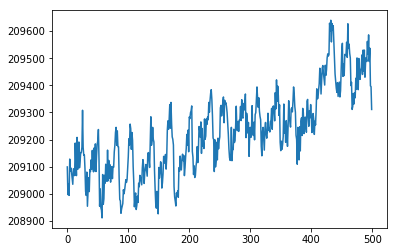

[209099.0, 208997.0, 209036.0, 208994.0, 209128.0, 209083.0, 209095.0, 209078.0, 209055.0, 209035.0, 209092.0, 209092.0, 209067.0, 209187.0, 209115.0, 209067.0, 209208.0, 209090.0, 209133.0, 209191.0, 209096.0, 209120.0, 209152.0, 209152.0, 209172.0, 209308.0, 209171.0, 209142.0, 209143.0, 209092.0, 209009.0, 208994.0, 209080.0, 208954.0, 209010.0, 209059.0, 209008.0, 209089.0, 209082.0, 209125.0, 209091.0, 209160.0, 209100.0, 209081.0, 209169.0, 209085.0, 209184.0, 209082.0, 209141.0, 209183.0]


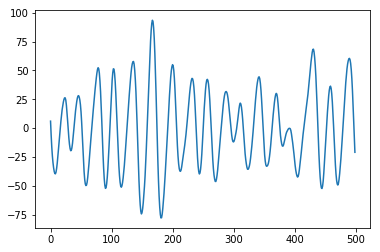

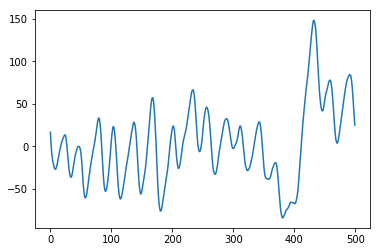

In [6]:
per_data = np.genfromtxt('sleeping2.csv', delimiter=',') #pull in the data from the csv (generates matrix)

time = column(per_data, 0)[1:] #use the function we came up with earlier to pull out the columns for time, ir, red
ir = column(per_data, 2)[1:]
red = column(per_data, 1)[1:]


Fs = 50.0 # Sample rate in Hz
Ts = 1.0/Fs # sampling interval


#Cutoff frequencies in Hz
heart_rate_lowcut = 0.8
heart_rate_highcut = 1.8

respiration_lowcut = 0.2
respiration_highcut = 1.5

#filter data
filtered_heart_rate_ir = butter_bandpass_filter(ir, heart_rate_lowcut, heart_rate_highcut, Fs, order=1)
filtered_respiration_ir = butter_bandpass_filter(ir, respiration_lowcut, respiration_highcut, Fs, order=1)

plt.plot(ir[50:550])
plt.show()
print(ir[50:100])

plt.plot(filtered_heart_rate_ir[50:550])
plt.show()

plt.plot(filtered_respiration_ir[50:550])
plt.show()

0.02
1.31


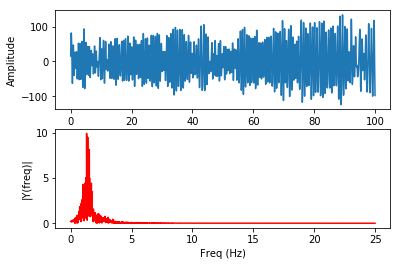

In [7]:
print(Ts)
duration = 100.0   # in seconds, may be float
t = np.arange(0,duration,Ts) # time vector

# ff = 5;   # frequency of the signal
# y = np.sin(2*np.pi*ff*t)


# volume = 0.5     # range [0.0, 1.0]
# fs = 50       # sampling rate, Hz, must be integer

# f = 1.3573        # sine frequency, Hz, may be float

# generate samples, note conversion to float32 array
# y = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)



y = filtered_heart_rate_ir[0:5000]

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n//2)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n//2)]

freqs = np.fft.fftfreq(len(Y),d=2)
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

# Find the peak in the coefficients
idx = np.argmax(np.abs(Y))
freq = freqs[idx]
freq_in_hertz = abs(freq*50)
print(freq_in_hertz)

# for coef,freq in zip(Y,freqs):
#     if coef:
#         print('Y: {} Freq: {}'.format(coef,freq))

0.02
1.31


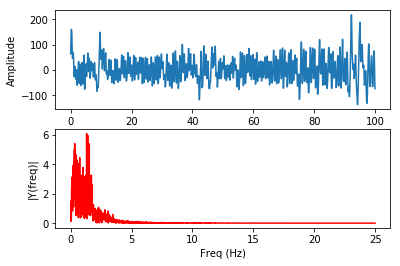

In [8]:
print(Ts)
duration = 100.0   # in seconds, may be float
t = np.arange(0,duration,Ts) # time vector

# ff = 5;   # frequency of the signal
# y = np.sin(2*np.pi*ff*t)


# volume = 0.5     # range [0.0, 1.0]
# fs = 50       # sampling rate, Hz, must be integer

# f = 1.3573        # sine frequency, Hz, may be float

# generate samples, note conversion to float32 array
# y = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)



y = filtered_respiration_ir[0:5000]

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n//2)] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n//2)]

freqs = np.fft.fftfreq(len(Y),d=2)
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

# Find the peak in the coefficients
idx = np.argmax(np.abs(Y))
freq = freqs[idx]
freq_in_hertz = abs(freq*50)
print(freq_in_hertz)

In [9]:

print('---------- PRINTING Heart Rate VALUES -----------')
hRates = []
index = 0
window_size = 5
upperbound = 0
lowerbound = 0
while True:
    lowerbound, upperbound = generateWindow(index,window_size) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
    if upperbound > len(filtered_heart_rate_ir):
        break
    irSlice = filtered_heart_rate_ir[lowerbound:upperbound] #filtered data
    y = irSlice

    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    freqs = np.fft.fftfreq(len(Y),d=2)

    # Find the peak in the coefficients
    idx = np.argmax(np.abs(Y))
    freq = freqs[idx]
    freq_in_hertz = abs(freq*50)
    
    hRate = freq_in_hertz*60
    hRates.append(hRate)
    print("LB: {}, UB: {}, BPM: {}".format(lowerbound,upperbound,hRate))
    index = upperbound
print('Mean: {}'.format(np.array(hRates).mean()))
print('---------- END Heart Rate VALUES ---------------')

---------- PRINTING Heart Rate VALUES -----------
LB: 0, UB: 250, BPM: 108.00000000000001
LB: 250, UB: 500, BPM: 108.00000000000001
LB: 500, UB: 750, BPM: 96.0
LB: 750, UB: 1000, BPM: 84.00000000000001
LB: 1000, UB: 1250, BPM: 96.0
LB: 1250, UB: 1500, BPM: 96.0
LB: 1500, UB: 1750, BPM: 84.00000000000001
LB: 1750, UB: 2000, BPM: 84.00000000000001
LB: 2000, UB: 2250, BPM: 72.0
LB: 2250, UB: 2500, BPM: 108.00000000000001
LB: 2500, UB: 2750, BPM: 108.00000000000001
LB: 2750, UB: 3000, BPM: 84.00000000000001
LB: 3000, UB: 3250, BPM: 96.0
LB: 3250, UB: 3500, BPM: 84.00000000000001
LB: 3500, UB: 3750, BPM: 84.00000000000001
LB: 3750, UB: 4000, BPM: 84.00000000000001
LB: 4000, UB: 4250, BPM: 84.00000000000001
LB: 4250, UB: 4500, BPM: 72.0
LB: 4500, UB: 4750, BPM: 84.00000000000001
LB: 4750, UB: 5000, BPM: 60.0
LB: 5000, UB: 5250, BPM: 72.0
LB: 5250, UB: 5500, BPM: 84.00000000000001
LB: 5500, UB: 5750, BPM: 84.00000000000001
LB: 5750, UB: 6000, BPM: 72.0
LB: 6000, UB: 6250, BPM: 72.0
LB: 6250, 

In [10]:
print('---------- PRINTING Heart Rate VALUES -----------')
hRates = []
index = 0
window_size = 30
upperbound = 0
lowerbound = 0
while True:
    lowerbound, upperbound = generateWindow(index,window_size) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
    if upperbound > len(filtered_heart_rate_ir):
        break
    irSlice = filtered_heart_rate_ir[lowerbound:upperbound] #filtered data
    peaks = signal.argrelmax(irSlice, order=25)[0]
    hRate = (len(peaks)/window_size)*60
    hRates.append(hRate)
    print("LB: {}, UB: {}, num peaks: {}, BPM: {}".format(lowerbound,upperbound,len(peaks),hRate))
    index = upperbound
print('Mean: {}'.format(np.array(hRates).mean()))
print('---------- END Heart Rate VALUES ---------------')  

print('---------- PRINTING RR VALUES -----------')
rRates = []
index = 0
window_size = 30
upperbound = 0
lowerbound = 0
while True:
    lowerbound, upperbound = generateWindow(index,window_size) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
    if upperbound > len(filtered_respiration_ir):
        break
    irSlice = filtered_respiration_ir[lowerbound:upperbound] #filtered data
    peaks = signal.argrelmax(irSlice, order=75)[0]
    rRate = (len(peaks)/window_size)*60
    rRates.append(rRate)
    print("LB: {}, UB: {}, num peaks: {}, RPM: {}".format(lowerbound,upperbound,len(peaks),rRate))
    index = upperbound
print('Mean: {}'.format(np.array(rRates).mean()))
print('---------- END RR VALUES ---------------')    



---------- PRINTING Heart Rate VALUES -----------
LB: 0, UB: 1500, num peaks: 40, BPM: 80.0
LB: 1500, UB: 3000, num peaks: 38, BPM: 76.0
LB: 3000, UB: 4500, num peaks: 41, BPM: 82.0
LB: 4500, UB: 6000, num peaks: 36, BPM: 72.0
LB: 6000, UB: 7500, num peaks: 39, BPM: 78.0
LB: 7500, UB: 9000, num peaks: 37, BPM: 74.0
LB: 9000, UB: 10500, num peaks: 43, BPM: 86.0
LB: 10500, UB: 12000, num peaks: 38, BPM: 76.0
LB: 12000, UB: 13500, num peaks: 37, BPM: 74.0
LB: 13500, UB: 15000, num peaks: 36, BPM: 72.0
LB: 15000, UB: 16500, num peaks: 38, BPM: 76.0
LB: 16500, UB: 18000, num peaks: 37, BPM: 74.0
LB: 18000, UB: 19500, num peaks: 43, BPM: 86.0
LB: 19500, UB: 21000, num peaks: 37, BPM: 74.0
LB: 21000, UB: 22500, num peaks: 38, BPM: 76.0
LB: 22500, UB: 24000, num peaks: 38, BPM: 76.0
LB: 24000, UB: 25500, num peaks: 39, BPM: 78.0
LB: 25500, UB: 27000, num peaks: 39, BPM: 78.0
LB: 27000, UB: 28500, num peaks: 36, BPM: 72.0
LB: 28500, UB: 30000, num peaks: 38, BPM: 76.0
Mean: 76.8
---------- END 

In [11]:
ir = ir_spo2


b, a = signal.butter(4, [0.0340, 0.0354], btype='bandpass') #filter for heart rate
hrdata = signal.lfilter(b, a, ir)

b, a = signal.butter(4, 0.8, btype='lowpass') #filter for SPO2, just removing hf noise
filteredReddata = signal.filtfilt(b, a, red, method='gust') #using filtfilt to avoid phase shift
filteredIRdata = signal.filtfilt(b, a, ir, method='gust')

b, a = signal.butter(4, [0.00972, 0.0113], btype='bandpass') #filter for breathing rate
rrdata = signal.filtfilt(b, a, ir)

hrPeaks = signal.argrelextrema(filtered_heart_rate_ir, np.greater_equal, order=30)[0] #find the peaks for HR and breathing rate
rrPeaks = signal.argrelextrema(filtered_respiration_ir, np.greater_equal, order=100)[0]

heartRates = np.zeros(len(hrPeaks))
print('---------- PRINTING INSTANT HR VALUES -----------')
for peakIndex in range(len(hrPeaks) - 1):
    distance = hrPeaks[peakIndex + 1] - hrPeaks[peakIndex]
#     print(60 / (distance * 0.02))
    heartRates[peakIndex] = (60 / (distance * 0.02))
print(heartRates)

print('Mean: {}'.format(np.array(heartRates).mean()))
print('---------- END HR VALUES ---------------')

rRates = []
print('---------- PRINTING INSTANT RR VALUES -----------')
for peakIndex in range(len(rrPeaks) - 1):
    distance = rrPeaks[peakIndex + 1] - rrPeaks[peakIndex]
    print(60 / (distance * 0.02))
    rRates.append(60 / (distance * 0.02))
print('Mean: {}'.format(np.array(rRates).mean()))
print('---------- END RR VALUES ---------------')

---------- PRINTING INSTANT HR VALUES -----------
[ 25.42372881  33.70786517  17.14285714  33.70786517  50.84745763
  88.23529412  34.09090909  90.90909091  83.33333333  90.90909091
  85.71428571  43.47826087  93.75        76.92307692  31.25        18.98734177
  44.7761194   46.875       90.90909091  44.7761194   46.15384615
  33.33333333  45.45454545  76.92307692  83.33333333  88.23529412
  76.92307692  75.          90.90909091  88.23529412  83.33333333
  32.96703297  76.92307692  88.23529412  69.76744186  68.18181818
  83.33333333  90.90909091  47.61904762  55.55555556  34.48275862
  35.29411765  52.63157895  51.72413793  33.70786517  76.92307692
  88.23529412  90.90909091  81.08108108  85.71428571  23.4375      83.33333333
  48.38709677  44.11764706  90.90909091  76.92307692  75.          85.71428571
  88.23529412  73.17073171  83.33333333  85.71428571  44.7761194
  85.71428571  85.71428571  32.25806452  69.76744186  78.94736842
  83.33333333  88.23529412  73.17073171  81.08108108  

In [13]:
print('---------- PRINTING Heart Rate VALUES -----------')
hRates = []
index = 0
window_size = 5
upperbound = 0
lowerbound = 0

hrPeaks = signal.argrelextrema(filtered_heart_rate_ir, np.greater_equal, order=30)[0] #find the peaks for HR and breathing rate
rrPeaks = signal.argrelextrema(filtered_respiration_ir, np.greater_equal, order=100)[0]

while True:
    lowerbound, upperbound = generateWindow(index,window_size) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
    if upperbound > len(filtered_heart_rate_ir):
        break
    irSlice = filtered_heart_rate_ir[lowerbound:upperbound] #filtered data
    
    distance = hrPeaks[peakIndex + 1] - hrPeaks[peakIndex]
    print(60 / (distance * 0.02))
    heartRates.append(60 / (distance * 0.02))    
    
    index = upperbound
print('---------- END Heart Rate VALUES ---------------')

---------- PRINTING Heart Rate VALUES -----------
38.4615384615


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:


# redDC = []
# redAC = []
# irDC = []
# irAC = []

# for second in range(89):
#     lb, ub = generateWindow(index,4) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
#     redSlice = filteredReddata[lb:ub]
#     irSlice = filteredIRdata[lb:ub] #filtered data
#     valleys = signal.argrelmin(redSlice, order=10)[0] #find peaks and valleys
#     peaks = signal.argrelmax(redSlice, order=10)[0]
#     valley1 = valleys[0] + lb
#     valley2 = valleys[1] + lb
#     peak = peaks[0] + lb
#     if (peak < valley1): #to make sure the peak is between the valleys
#         peak = peaks[1] + lb
#     dcir = np.interp(peak, [valley1, valley2], [filteredIRdata[valley1], filteredIRdata[valley2]])
#     dcred = np.interp(peak, [valley1, valley2], [filteredReddata[valley1], filteredReddata[valley2]])
#     irDC += [dcir]
#     irAC += [filteredIRdata[peak] - dcir]
#     redDC += [dcred]
#     redAC += [filteredReddata[peak] - dcred]
#     index = ub
    
# print('---------- PRINTING SPO2 VALUES -----------')
# for iteration in range(len(redDC)):
#     print(calculateSPO2(getRatio(redAC[iteration], irDC[iteration], irAC[iteration], redDC[iteration])))
# print('---------- END SPO2 VALUES -----------')